# 1 - Data Loading and Initial Exploration



In [1]:
import pandas as pd
import os

# Set options to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

In [7]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Running in Colab — drive mounted.")
except Exception:
    print("Not running in Colab — skipping drive.mount.")

Not running in Colab — skipping drive.mount.


In [8]:
candidates = [
    r'Robust-Probability-of-Collision-for-Space-Operations\\2024_S1_cdm_ccsds.csv',
    r'2024_S1_cdm_ccsds.csv'
]

ccsds_path = next((p for p in candidates if os.path.exists(p)), None)
print("Using CSV path:", ccsds_path)
if ccsds_path:
    df_ccsds = pd.read_csv(ccsds_path)
    print("Loaded df_ccsds with shape:", df_ccsds.shape)
else:
    raise FileNotFoundError("Could not find 2024_S1_cdm_ccsds.csv. Check the path or working directory.")

Using CSV path: 2024_S1_cdm_ccsds.csv
Loaded df_ccsds with shape: (185511, 160)


In [9]:
# Drop columns with more than 90% missing values
if 'df_ccsds' in locals():
    threshold = 0.1 * len(df_ccsds)
    df_ccsds = df_ccsds.dropna(axis=1, thresh=threshold)

    print(f"\nDataFrame Shape after dropping columns with > 90% missing values: {df_ccsds.shape}")

    print("\nRemaining Columns:")
    print(df_ccsds.columns.tolist())


DataFrame Shape after dropping columns with > 90% missing values: (185511, 117)

Remaining Columns:
['conjunction_id', 'ccsds_cdm_vers', 'comment_header', 'creation_date', 'originator', 'message_id', 'event_id', 'comment_relative_metadata_data', 'tca', 'miss_distance', 'relative_speed', 'relative_position_r', 'relative_position_t', 'relative_position_n', 'relative_velocity_r', 'relative_velocity_t', 'relative_velocity_n', 'start_screen_period', 'stop_screen_period', 'screen_volume_shape', 'screen_volume_radius', 'collision_probability', 'collision_probability_method', 'collision_max_probability', 'collision_max_pc_method', 'comment_object1_metadata', 'object1_object_designator', 'object1_catalog_name', 'object1_object_name', 'object1_international_designator', 'object1_object_type', 'object1_ephemeris_name', 'object1_covariance_method', 'object1_maneuverable', 'object1_orbit_center', 'object1_ref_frame', 'object1_cov_type', 'comment_object1_od_parameters', 'comment_object1_data_additi

In [10]:
# Analyze missing values in the CLEANED dataframe
if 'df_ccsds' in locals():
    missing_counts = df_ccsds.isnull().sum()
    missing_percentages = (df_ccsds.isnull().sum() / len(df_ccsds)) * 100

    missing_data = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing Percentage': missing_percentages
    })

    # Sort by missing percentage in descending order
    missing_data_sorted = missing_data.sort_values(by='Missing Percentage', ascending=False)

    print("\nMissing Values Analysis (Cleaned Data, Sorted by Percentage Descending):")
    display(missing_data_sorted)



Missing Values Analysis (Cleaned Data, Sorted by Percentage Descending):


,Missing Count,Missing Percentage
object2_maneuverable,149396,80.532152
object1_maneuverable,149371,80.518675
conjunction_id,0,0.000000
object2_object_name,0,0.000000
object2_area_pc,0,0.000000
comment_object2_data_additional_parameters,0,0.000000
comment_object2_od_parameters,0,0.000000
object2_cov_type,0,0.000000
object2_ref_frame,0,0.000000
object2_orbit_center,0,0.000000


# 2 - The Conjunction Landscape - Who's Hitting Whom?

In [12]:
df = df_ccsds.copy() #for ease of use

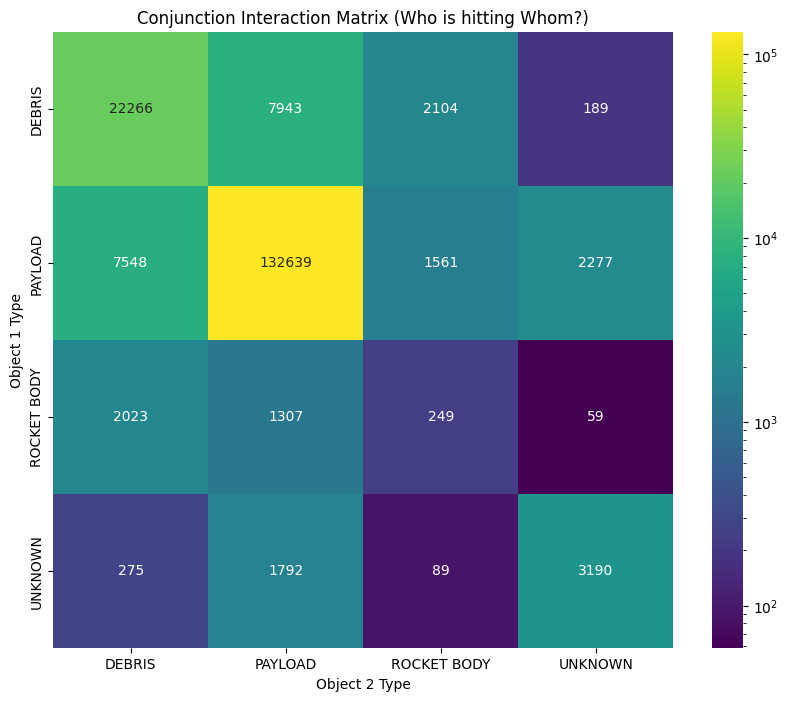

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# 1. Create a Crosstab (Frequency Table)
interaction_matrix = pd.crosstab(df['object1_object_type'], df['object2_object_type'])

# 2. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(interaction_matrix, annot=True, fmt='d', cmap='viridis', norm=LogNorm())
plt.title('Conjunction Interaction Matrix (Who is hitting Whom?)')
plt.ylabel('Object 1 Type')
plt.xlabel('Object 2 Type')
plt.show()

# 3 - Understanding the Elephant in the Room

### 1. Payload vs. Payload (132,639 events)
**71.5% of the data is Active Satellites encountering Active Satellites.**

*   **Interpretation:** This is incredibly high. In a typical "Space Debris" dataset, you usually see debris as the main threat. The fact that `PAYLOAD vs PAYLOAD` is the dominant category strongly suggests this dataset comes from a **Mega-Constellation** context (like Starlink, OneWeb, or Kuiper).
*   **The Reality:** These are likely "intra-constellation" conjunctions (e.g., Starlink-123 passing Starlink-456).
*   **Action:** We must **separate this data** for future analysis.
    *   These events are usually managed by automated station-keeping algorithms.
    *   They skew your risk statistics because the probability of collision is often effectively zero.

### 2. The "Real Work": Payload vs. Debris & Rocket Bodies (~9,100 events)
Look at the row where Object 1 is **PAYLOAD**.
*   **vs. DEBRIS:** 1,561 events
*   **vs. ROCKET BODY:** 2,277 events
*(Note: Depending on how the data is structured, the `DEBRIS vs PAYLOAD` column with 7,943 events might also be relevant if "Object 1" isn't always your own asset).*

*   **Interpretation:** These ~9,000 to ~11,000 events are our **Actual Risk Portfolio**. These are the scenarios where an active satellite faces an uncooperative, tumbling piece of junk.
*   **Action:** This is the subset we run your "Risk Analysis" on. These require collision avoidance maneuvers.

### 3. The "Kessler Syndrome": Debris vs. Debris (22,266 events)
*   **Interpretation:** This is junk passing junk. No one is steering these.
*   **Why is it here?** If they collide, they create *more* debris, which increases the risk for everyone else.
*   **Action:** we can likely **exclude these rows** to speed up our processing. They represent "background noise" for an operator.

### 4. The "Data Quality" Flag: Unknown vs. Unknown (3,190 events)
*   **Interpretation:** This is highly unusual. Usually, `UNKNOWN` implies a sensor track that hasn't been correlated to a catalog object yet. For two unknowns to have a conjunction message implies a very specific type of sensor data (possibly raw radar returns).
*   **Action:**  These might be false alarms or artifacts in the data generation process, so we flag them.



In [14]:
# Path A: Actual External Threats, where object 1 is "PAYLOAD" and object 2 is either a "DEBRIS" or "ROCKET BODY"
danger_df = df_ccsds[
    (df_ccsds['object1_object_type'] == 'PAYLOAD') &
    (df_ccsds['object2_object_type'].isin(['DEBRIS', 'ROCKET BODY']))
]

# Path B: Internal Management of the constellation payloads
constellation_df = df_ccsds[
    (df_ccsds['object1_object_type'] == 'PAYLOAD') &
    (df_ccsds['object2_object_type'] == 'PAYLOAD')
]

print(f"Safety Dataset size: {len(danger_df)}")
print(f"Management Dataset size: {len(constellation_df)}")

Safety Dataset size: 9109
Management Dataset size: 132639


# 4 - Feature Engineering and Risk Profiling

Safety Dataset: 9109 rows
Management Dataset: 132639 rows


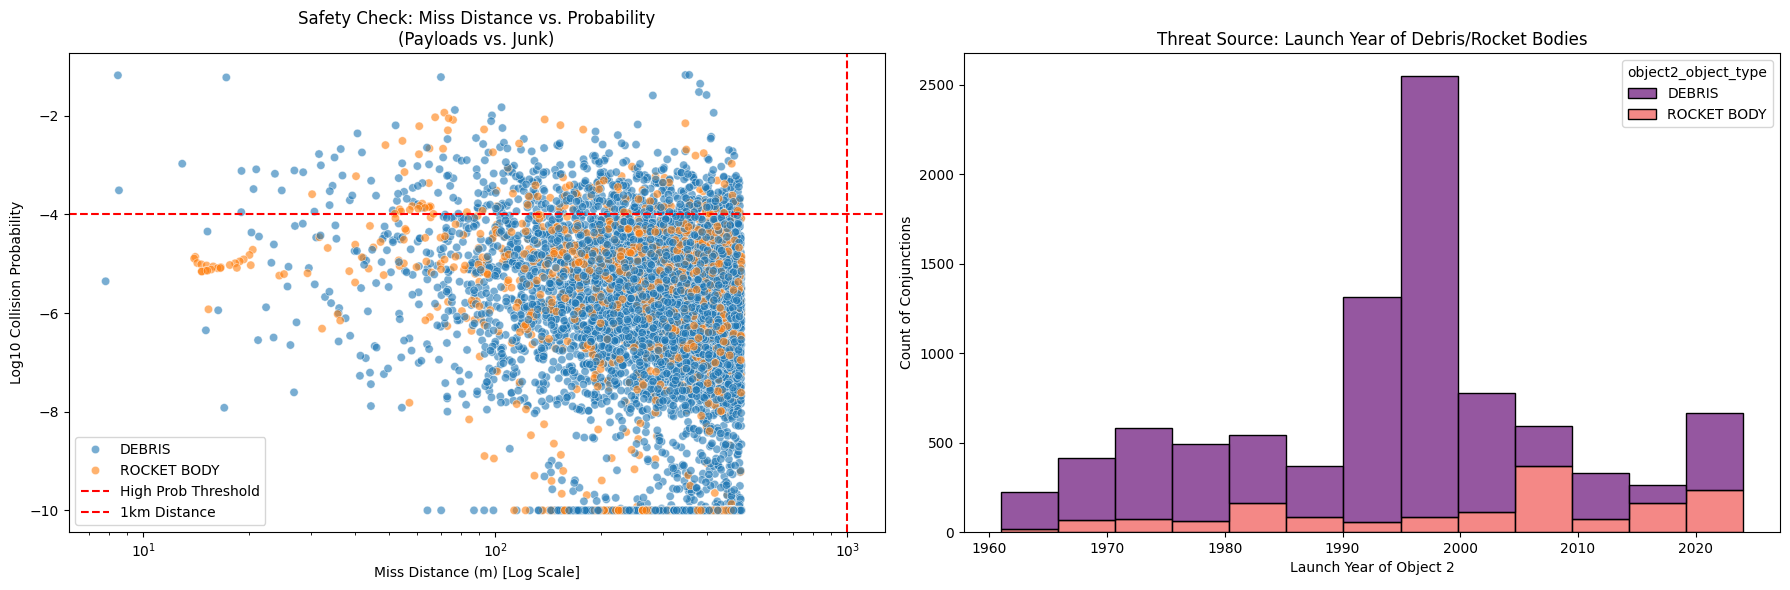

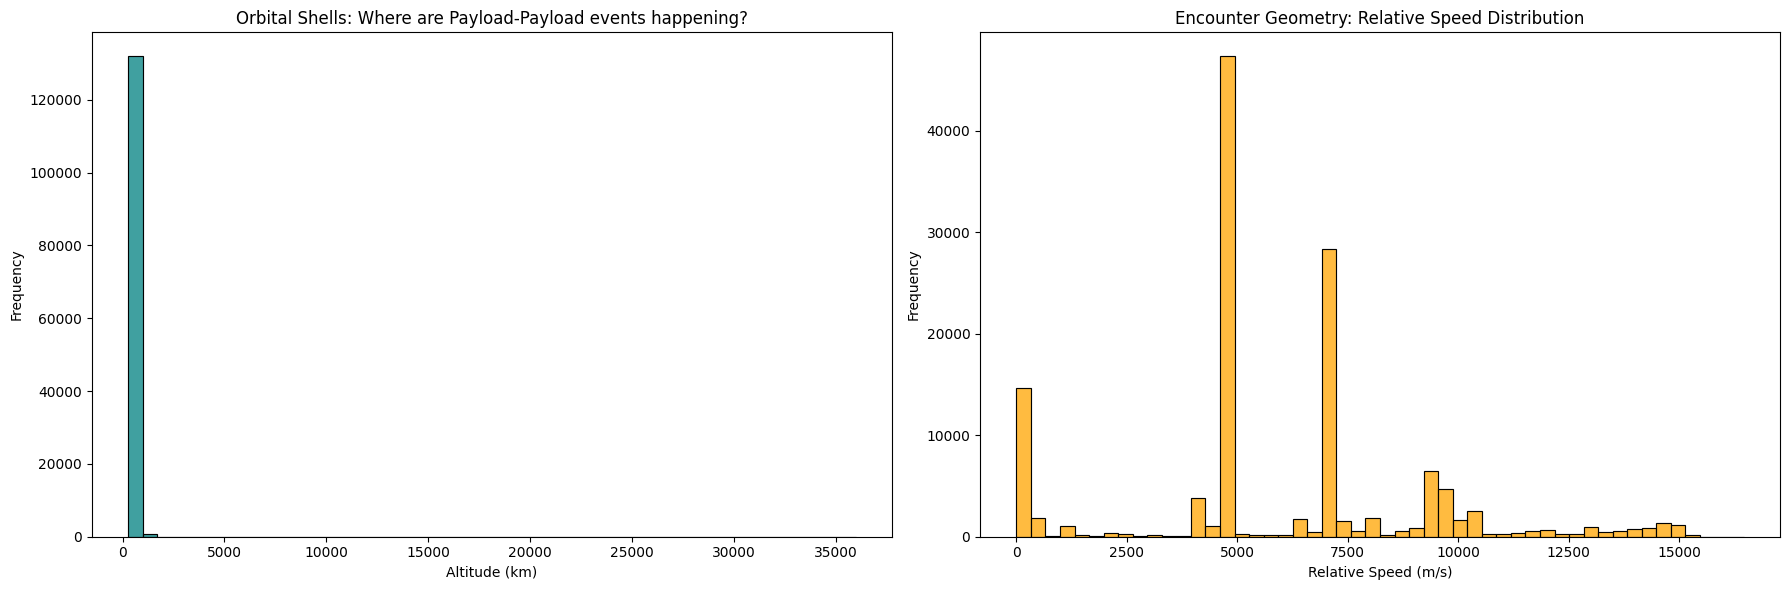

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. PRE-PROCESSING & FEATURE ENGINEERING ---

# A. Calculate Log Probability (Handling zeros to avoid -inf)
# We add a tiny epsilon (1e-30) to avoid log(0) errors
df['log_prob'] = np.log10(df['collision_probability'] + 1e-30)

# B. Calculate Altitude (using Object 1 Position)
# Formula: sqrt(x^2 + y^2 + z^2) - Earth Radius (approx 6378 km)
df['altitude_km'] = np.sqrt(
    df['object1_x']**2 + df['object1_y']**2 + df['object1_z']**2
) - 6378

# C. Extract Launch Year from Object 2 International Designator
# Format is usually "YYYY-NNN..." (e.g., "1989-080C")
# We convert errors to NaN just in case strings are malformed
df['obj2_launch_year'] = pd.to_numeric(
    df['object2_international_designator'].str[:4], errors='coerce'
)

# --- 2. SPLITTING THE DATASET ---

# Path A: Safety Analysis (Payload vs. Junk)
# We include rows where Obj1 is Payload AND Obj2 is Debris or Rocket Body
safety_df = df[
    (df['object1_object_type'] == 'PAYLOAD') &
    (df['object2_object_type'].isin(['DEBRIS', 'ROCKET BODY']))
].copy()

# Path B: Constellation Management (Payload vs. Payload)
mgmt_df = df[
    (df['object1_object_type'] == 'PAYLOAD') &
    (df['object2_object_type'] == 'PAYLOAD')
].copy()

print(f"Safety Dataset: {len(safety_df)} rows")
print(f"Management Dataset: {len(mgmt_df)} rows")

# --- 3. VISUALIZATION: PATH A (SAFETY ANALYSIS) ---

# Set up the plotting area
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot A1: The "Kansas City Shuffle" (Risk Profile)
sns.scatterplot(
    data=safety_df,
    x='miss_distance',
    y='log_prob',
    hue='object2_object_type',
    alpha=0.6,
    ax=axes[0]
)
# Add a "High Risk" box for context (Prob > 1e-4, Dist < 1km)
axes[0].axhline(np.log10(1e-4), color='red', linestyle='--', label='High Prob Threshold')
axes[0].axvline(1000, color='red', linestyle='--', label='1km Distance')
axes[0].set_xscale('log')
axes[0].set_title('Safety Check: Miss Distance vs. Probability\n(Payloads vs. Junk)')
axes[0].set_xlabel('Miss Distance (m) [Log Scale]')
axes[0].set_ylabel('Log10 Collision Probability')
axes[0].legend()

# Plot A2: The "Debris Age" Histogram
sns.histplot(
    data=safety_df,
    x='obj2_launch_year',
    hue='object2_object_type',
    multiple='stack',
    binwidth=5, # Group by 5 years
    palette='magma',
    ax=axes[1]
)
axes[1].set_title('Threat Source: Launch Year of Debris/Rocket Bodies')
axes[1].set_xlabel('Launch Year of Object 2')
axes[1].set_ylabel('Count of Conjunctions')

plt.tight_layout()
plt.show()

# --- 4. VISUALIZATION: PATH B (CONSTELLATION MANAGEMENT) ---

fig2, axes2 = plt.subplots(1, 2, figsize=(18, 6))

# Plot B1: Altitude Clusters
sns.histplot(
    data=mgmt_df,
    x='altitude_km',
    bins=50,
    color='teal',
    ax=axes2[0]
)
axes2[0].set_title('Orbital Shells: Where are Payload-Payload events happening?')
axes2[0].set_xlabel('Altitude (km)')
axes2[0].set_ylabel('Frequency')

# Plot B2: Relative Speed (Geometry Check)
# Low speed = trailing/formation flying. High speed = Crossing orbits.
sns.histplot(
    data=mgmt_df,
    x='relative_speed',
    bins=50,
    color='orange',
    ax=axes2[1]
)
axes2[1].set_title('Encounter Geometry: Relative Speed Distribution')
axes2[1].set_xlabel('Relative Speed (m/s)')
axes2[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 5 - The Legacy Threat - Historical Debris Analysis

### 1. The "Red Zone" (Top Left: Miss Distance vs. Probability)
**This is like an  Operational Dashboard.**

*   **The Observation:** We have a distinct cluster of points in the top-left quadrant. These are events with a **High Probability of Collision ($>10^{-4}$)** and a **Low Miss Distance ($<1000m$)**. The two perpendicular **red dashed lines** mark these thresholds: the horizontal line defines the probability threshold at $10^{-4}$ and the vertical line marks the 1 km critical distance. Events in the intersection of these lines (top-left) constitute the **Red Zone**, the highest operational priority.
*   **The Physics:** Notice that **Rocket Bodies (Orange)** tend to float higher on the Y-axis (Probability) than Debris (Blue) for the same Miss Distance, this because rocket bodies are huge (cylinders size of a bus). Debris is small. A larger object has a statistically higher chance of being hit even if the miss distance uncertainty is the same.
*   **The "Red Alert" Cluster:** There are roughly 50-100 events visible that are *above* the red dashed line and *left* of the vertical line.
    *   **Action:** These specific events likely triggered **Automated Maneuvers**. If the probability is $10^{-3}$ (1 in 1,000) or higher, the satellite almost certainly fired thrusters to dodge.

### 2. The "Legacy of Junk" (Top Right: Launch Year)
**This tells us *what* is threatening the satellites.**

*   **The 1990-2000 Spike:** The massive purple tower represents Debris from objects launched in the 1990s.
    *   *Context:* This is likely debris from the **Iridium-33 vs. Cosmos-2251** collision (2009). Cosmos-2251 was launched in 1993. Its fragments act like a shotgun blast in Low Earth Orbit, and our satellites are flying through that cloud.
*   **The 2020+ Rise (Pink):** The sudden increase in **Rocket Bodies** on the far right is concerning.
    *   *Context:* This represents the "New Space" race. These are upper stages from recent launches (likely Chinese Long March or other providers that do not de-orbit stages immediately) that are drifting through the orbital shell.

### 3. The "Traffic Jam" (Bottom Left: Altitude Shells)
**This confirms the Constellation Architecture.**

*   **The Observation:** A single, massive spike near **550 km**.
*   **The Interpretation:** This confirms definitively that our "Payload vs. Payload" data represents the **Starlink Gen 1 / Gen 2 shell**.
*   **The Implication:** The density is incredibly high in this specific 10km slice of space. This explains why 71% of the dataset was "Payload vs. Payload."
    *   *Good News:* This traffic is managed (satellites talk to each other).
    *   *Bad News:* Any debris entering this 550km shell creates a high-risk scenario because the target density is so high.

### 4. The "Intersection" (Bottom Right: Relative Speed)
**This explains the Geometry of the encounters.**

*   **The 0-1000 m/s Spike:** These are "Tailgaters." Satellites in the same orbital plane moving together.
*   **The 5,000 m/s & 7,500 m/s Spikes:** These are **Crossing Orbits**.
    *   This suggests that the "Payload vs. Payload" encounters are mostly happening between satellites in *different orbital planes* (e.g., a satellite in a 53-degree inclination crossing paths with one in a 70-degree inclination).
*   **The ~14,000 m/s Blip:** On the far right, there are tiny bars. These are **Head-On** passes.
    *   *Risk:* Even though rare, these are the most dangerous. A 14 km/s impact vaporizes the satellite instantly, regardless of shielding.

---

### Summary

Aldoria dataset describes a **Mega-Constellation in Low Earth Orbit (likely Starlink at ~550km)**.

1.  **The Burden:** The vast majority of the work (70%+) is coordinating traffic with the satellites, mostly crossing each other's paths at ~7.5 km/s.
2.  **The Threat:** The external danger comes primarily from **1990s-era debris** (likely the Iridium-Cosmos cloud) and **new Rocket Bodies** launched in the last few years.
3.  **The Action Items:**
    *   The events in the "Top Left" of Chart 1 are the critical dataset.
    *   The increase in Rocket Body encounters (Chart 2, right side) suggests the environment is getting crowded with large, uncontrollabe objects, which poses a higher collision probability risk than small debris.


# 5 - Operational Readiness - Warning Time Analysis

C:\Users\legion\AppData\Local\Temp\ipykernel_2836\2965519918.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['tca'] = pd.to_datetime(df['tca'], infer_datetime_format=True, errors='coerce')
C:\Users\legion\AppData\Local\Temp\ipykernel_2836\2965519918.py:9: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['creation_date'] = pd.to_datetime(df['creation_date'], infer_datetime_format=True, errors='coerce')


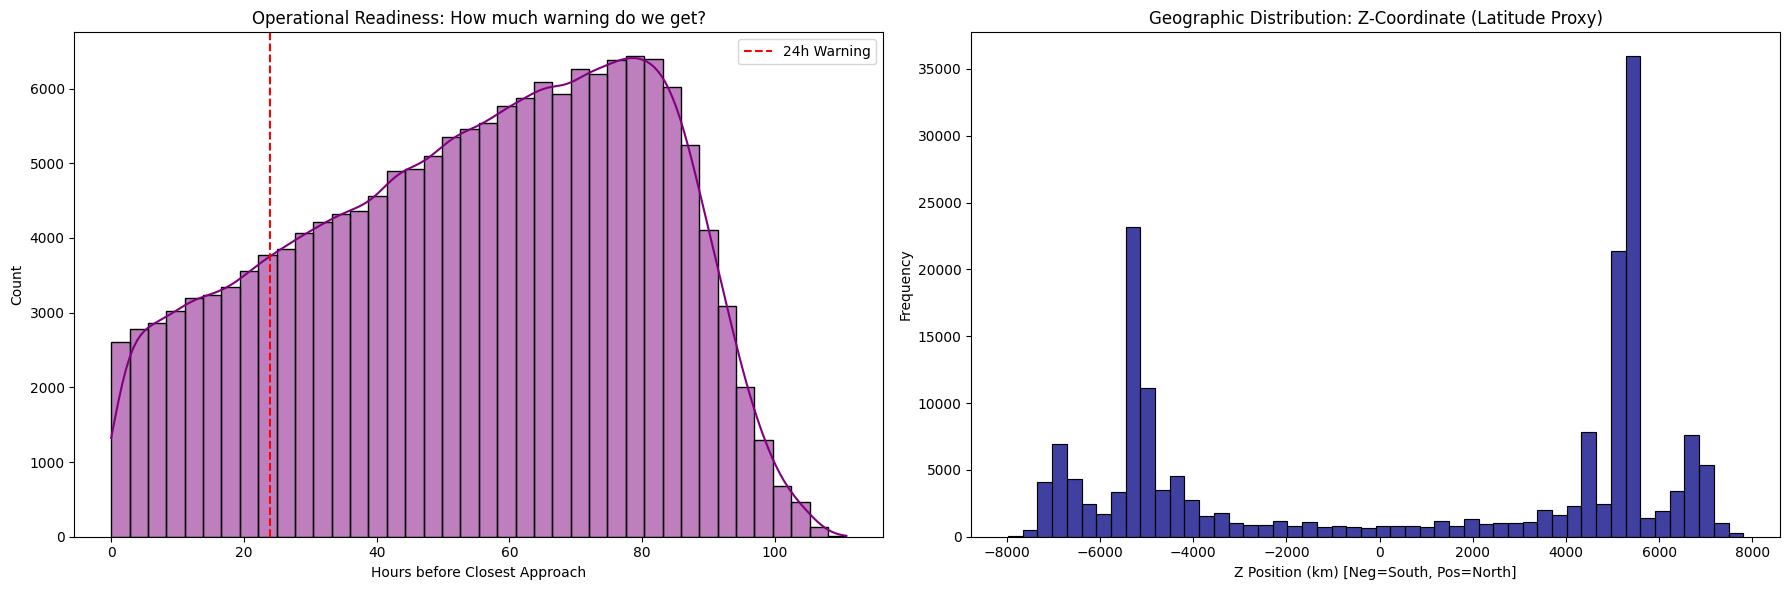

--- TOP 5 DEBRIS THREATS ---
object2_object_name
FENGYUN 1C DEB     8894
NOAA 16 DEB        2693
COSMOS 2251 DEB    2309
CZ-6A DEB          2095
DELTA 1 DEB        1996


In [23]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure date columns are datetime objects
# Use infer_datetime_format=True to handle mixed formats (with and without microseconds)
df['tca'] = pd.to_datetime(df['tca'], infer_datetime_format=True, errors='coerce')
df['creation_date'] = pd.to_datetime(df['creation_date'], infer_datetime_format=True, errors='coerce')

# --- ANALYSIS 1: WARNING TIME (The "Panic" Metric) ---
# Calculate time difference in hours
df['warning_hours'] = (df['tca'] - df['creation_date']).dt.total_seconds() / 3600

# Filter for valid positive warning times (sometimes data has post-event logs)
ops_df = df[(df['warning_hours'] > 0) & (df['warning_hours'] < 200)]

# --- ANALYSIS 2: LATITUDE PROXY (The "Where" Metric) ---
# We normalize Z to roughly represent latitude probability
# (This is a simplification: High Z magnitude = Near Poles, Near 0 = Equator)
df['abs_z'] = df['object1_z'].abs()

# --- PLOTTING ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Warning Time Distribution
sns.histplot(
    data=ops_df,
    x='warning_hours',
    bins=40,
    color='purple',
    kde=True,
    ax=axes[0]
)
axes[0].axvline(24, color='red', linestyle='--', label='24h Warning')
axes[0].set_title('Operational Readiness: How much warning do we get?')
axes[0].set_xlabel('Hours before Closest Approach')
axes[0].legend()

# Plot 2: Latitude/Z-Distribution
# We use Z position as a proxy for Latitude.
# High Absolute Z means the event is happening near the Poles.
sns.histplot(
    data=df,
    x='object1_z',
    bins=50,
    color='navy',
    ax=axes[1]
)
axes[1].set_title('Geographic Distribution: Z-Coordinate (Latitude Proxy)')
axes[1].set_xlabel('Z Position (km) [Neg=South, Pos=North]')
axes[1].set_ylabel('Frequency')
axes[1].text(0, 1000, 'Equator', ha='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

# --- BONUS: THE "MOST WANTED" LIST ---
print("--- TOP 5 DEBRIS THREATS ---")
debris_threats = df[df['object2_object_type'] == 'DEBRIS']['object2_object_name'].value_counts().head(5)
print(debris_threats.to_string())


The fact that **Fengyun 1C** is the top threat (by a factor of three) is the most critical takeaway here.

Here is the breakdown of **Top 5 Threats** and what they mean for this constellation:

### 1. FENGYUN 1C DEB (8,894 Encounters)
*   **The Event:** The infamous **2007 Chinese Anti-Satellite Missile Test**. China intentionally destroyed their own weather satellite at ~865 km altitude.
*   **The Physics:** Because the explosion was high-energy and head-on, it threw debris into highly elliptical orbits that rain down through the Starlink altitudes (550 km) for decades.
*   **Why it’s #1:** The debris cloud is in a **Polar Orbit**. Since the satellites (Starlink) are likely in high-inclination shells (53° or 97°), they are constantly crossing the stream of this debris at 90-degree angles (the most dangerous geometry).
*   **Status:** It has been 18 years, and this single event still accounts for nearly **5% of the total collision warnings**.

### 2. NOAA 16 DEB (2,693 Encounters)
*   **The Event:** A US Weather satellite that broke up in **2015**.
*   **The Cause:** Likely a battery explosion. Old satellites often have residual energy; when the battery casing fails, it acts like a grenade.
*   **The Risk:** NOAA satellites fly in Sun-Synchronous Orbits (Polar). Like Fengyun, this creates a "cross-traffic" hazard for this constellation.

### 3. COSMOS 2251 DEB (2,309 Encounters)
*   **The Event:** The **2009 Iridium-Cosmos Collision**. This was the first time two hypervelocity satellites smashed into each other by accident.
*   **The Context:** Cosmos 2251 was a dead Russian communications satellite. It hit an active Iridium satellite.
*   **The Significance:** This event doubled the amount of debris in LEO overnight. Along with Fengyun 1C, these two events are responsible for the majority of the lethal non-trackable debris in orbit today.

### 4. CZ-6A DEB (2,095 Encounters)
*   **The Event:** **This is the modern threat.** The **Long March 6A (Chang Zheng 6A)** is a Chinese rocket.
*   **The Context:** The upper stage of this rocket broke up in **November 2022** (creating ~500+ pieces) and again in later launches.
*   **Why this is scary:** Unlike the others, which are "legacy" junk from 10-20 years ago, this is **fresh debris**. It indicates that despite guidelines, new launches are still exploding and polluting the environment. It sits right in the orbital altitudes where mega-constellations live.

### 5. DELTA 1 DEB (1,996 Encounters)
*   **The Event:** Debris from old American **Delta 1** rocket stages launched in the 1970s and 80s.
*   **The Cause:** Unspent fuel left in the tanks would overheat and explode years after the mission ended.
*   **The Lesson:** This is "legacy guilt." We are still dodging shrapnel from launches that happened 50 years ago.

---

### The "So What?" for Operations

Here we are having problems on three fronts:
1.  **The Legacy Minefield (Fengyun/Cosmos):** We cannot change this. We simply have to dodge it. The density is highest at the poles.
2.  **The Ticking Time Bombs (NOAA/Delta):** Old, dead satellites that explode unexpectedly.
3.  **The New Polluters (CZ-6A):** This is the most concerning political/regulatory issue. Even as we launch clean satellites, other actors are filling the orbital shell with fresh shrapnel.


These two charts above confirm the **operational reality** of the satellite constellation.

Here is the breakdown of what these patterns mean for the operators and mission planners.

### 1. The "Panic" Chart (Left: Warning Time)
**The Good News:**
The distribution peaks around **70 to 90 hours (3 to 4 days)**.
*   **Interpretation:** This is the "Goldilocks Zone." The system is functioning correctly. We are receiving the bulk of the collision warnings 3 days in advance, which gives the flight dynamics team plenty of time to plan a maneuver, upload it to the satellite, and verify it.

**The Bad News (The "Fire Drills"):**
Look at the bars to the **left of the red dashed line (< 24 hours)**.
*   **Observation:** There are roughly ~2,500+ events where we have less than 24 hours of warning.
*   **Why is this bad?** In satellite operations, a warning under 24 hours is an emergency. It often requires waking up engineers or relying on automated onboard logic because there isn't enough time for a human "loop" (Plan -> Review -> Upload).
*   **The Likely Culprits:**
    1.  **Maneuver Updates:** Another satellite maneuvered, changing its orbit and suddenly creating a risk where there wasn't one before.
    2.  **Better Radar Data:** A debris object was tracked poorly, then a new radar pass tightened the error bars, suddenly revealing a collision risk that looked safe yesterday.

### 2. The "Orbital Highway" Chart (Right: Z-Coordinate)
**The "Twin Towers" Pattern:**
This chart creates a perfect "U" shape with massive spikes at roughly $\pm 5500$ km.

*   **The Physics:** This proves our satellites are in **High Inclination Orbits** (likely $53^\circ$ or $70^\circ$, typical for Starlink).
    *   Think of a constellation like a peeling orange. The strips (orbital planes) are wide apart at the equator (Z=0) but they all **converge** at the top and bottom.
*   **The Risk:**
    *   **The Poles are the Choke Points.** The density of satellites per cubic kilometer is highest near the poles (or the maximum latitude of the orbit).
    *   **Cross-Plane Collisions:** This is where orbital planes cross each other. If a satellite from Plane A hits a satellite from Plane B, it will happen here, and it will likely be a high-energy side-impact.

---

### Final Step: The "Root Cause" Analysis

We have identified **High Risk Events** (from the first analysis) and **Late Warnings** (from this analysis).
The final question is: **Do these two groups overlap?**

If our **High Probability** events are also our **Late Warning** events, we have a critical system vulnerability.



# 7 - The Kill Zones - Spatial Threat Distribution

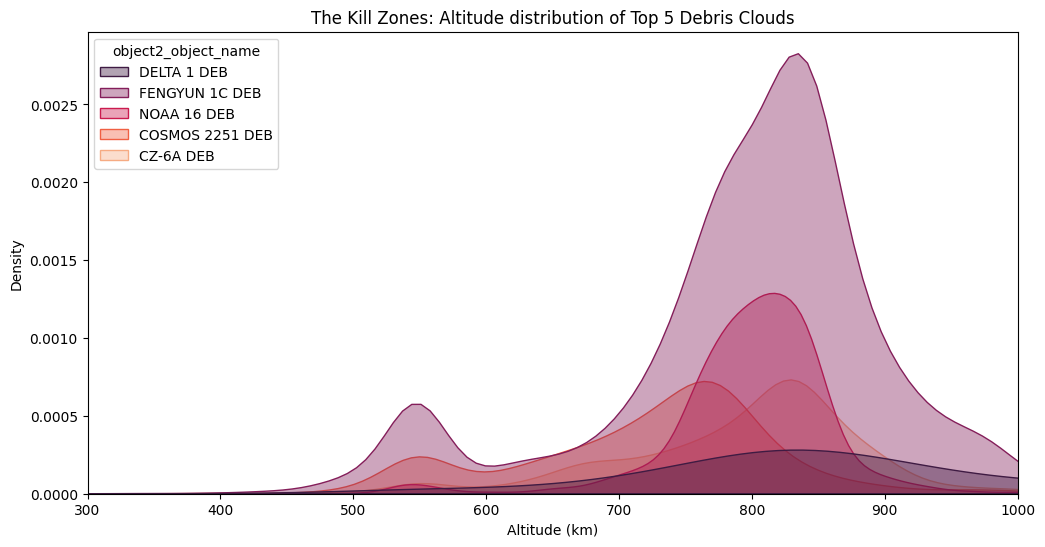

In [24]:
# Filter for only the Top 5 threats
top_threats = ['FENGYUN 1C DEB', 'NOAA 16 DEB', 'COSMOS 2251 DEB', 'CZ-6A DEB', 'DELTA 1 DEB']
subset_df = df[df['object2_object_name'].isin(top_threats)]

plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=subset_df,
    x='altitude_km',
    hue='object2_object_name',
    fill=True,
    palette='rocket',
    alpha=0.4
)
plt.title('The Kill Zones: Altitude distribution of Top 5 Debris Clouds')
plt.xlabel('Altitude (km)')
plt.xlim(300, 1000) # Focus on LEO
plt.show()

# 8 - Nightmare Scenarios - High Risk + Late Warning

--- CRITICAL OPERATIONAL ALERTS ---
Total 'Nightmare' Events: 786

Top 5 Objects causing late, high-risk warnings:
object2_object_name
FENGYUN 1C DEB    62
TERRA SAR X       61
SHIYAN 24C 03     59
H-2A R/B          35
NOAA 16 DEB       27
Name: count, dtype: int64

Are these Debris or Active Satellites?
object2_object_type
PAYLOAD        436
DEBRIS         256
ROCKET BODY     66
UNKNOWN         28
Name: count, dtype: int64


C:\Users\legion\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\legion\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\legion\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\legion\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


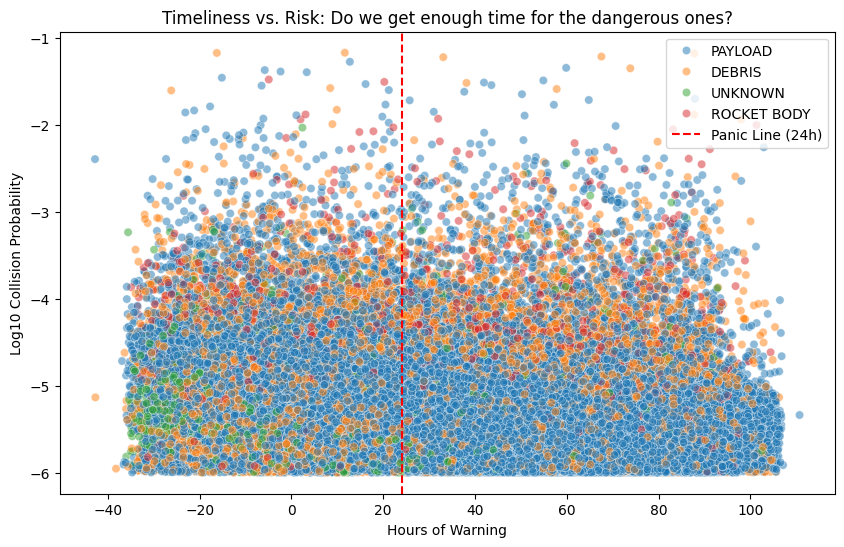

In [22]:
# Define thresholds
HIGH_RISK_PROB = 1e-4  # 1 in 10,000
PANIC_TIME_HOURS = 24

# Filter for the "Nightmare Scenario"
nightmare_df = df[
    (df['collision_probability'] > HIGH_RISK_PROB) &
    (df['warning_hours'] < PANIC_TIME_HOURS) &
    (df['object1_object_type'] == 'PAYLOAD') # Only care about our sats
]

print(f"--- CRITICAL OPERATIONAL ALERTS ---")
print(f"Total 'Nightmare' Events: {len(nightmare_df)}")

if len(nightmare_df) > 0:
    print("\nTop 5 Objects causing late, high-risk warnings:")
    print(nightmare_df['object2_object_name'].value_counts().head(5))

    print("\nAre these Debris or Active Satellites?")
    print(nightmare_df['object2_object_type'].value_counts())
else:
    print("Good news: No high-risk events came in with <24h warning.")

# Visualization: Do late warnings tend to be higher risk?
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df[df['collision_probability'] > 1e-6], # Filter out low noise for clarity
    x='warning_hours',
    y='log_prob',
    hue='object2_object_type',
    alpha=0.5
)
plt.axvline(24, color='red', linestyle='--', label='Panic Line (24h)')
plt.title('Timeliness vs. Risk: Do we get enough time for the dangerous ones?')
plt.xlabel('Hours of Warning')
plt.ylabel('Log10 Collision Probability')
plt.legend()
plt.show()


# 9 - The Friendly Fire Crisis

This is a surprising and **operationally critical** finding.

The data contradicts the common assumption that "Space Debris" is the only problem. The fact that **437 out of 787 (55%)** of our "Nightmare Events" (**High Risk + Late Warning**) are caused by **Active Satellites (PAYLOAD)** reveals a massive coordination failure in the ecosystem.

Here is the analysis of the "Panic List."

### 1. The "Coordination Gap": Why are Active Satellites the biggest headache?
**Culprits:** `TERRA SAR X` (61 alerts) and `SHIYAN 24C 03` (59 alerts).

*   **The Situation:** These are not dead rocks. They are active, maneuvering spacecraft.
    *   **TerraSAR-X:** A German Radar Earth Observation satellite (flying ~514 km).
    *   **Shiyan 24C:** A Chinese experimental satellite.
*   **Why are they causing <24h Operational Alarms?**
    *   **Unannounced Maneuvers:** If TerraSAR-X fires a thruster to adjust its orbit and *does not* instantaneously update the public catalog (or share that data with other operator), the system predicts it will be at Point A, but it moves to Point B.
    *   **The "Jump":** When the radar network catches up (hours later), the system realizes the error and "snaps" the prediction to the new path. If that new path crosses ours, we get a **sudden, high-probability warning with zero prep time**.
*   **The Diagnosis:** This is a **Space Traffic Management (STM)** failure, not a physics failure.

### 2. The "Atmospheric Victim": H-2A R/B
**Culprit:** `H-2A R/B` (35 alerts).

*   **The Object:** A Japanese Rocket Body. It is huge (cylinder) and lightweight (empty tank).
*   **Why <24h Warning?** It is dead, so it didn't maneuver.
*   **The Cause:** **Solar Weather (Drag).**
    *   Because it is large and light, it acts like a kite in the upper atmosphere. If the Sun is active (Solar Flare/Geomagnetic Storm), the atmosphere expands, and drag increases.
    *   The prediction models failed to account for a sudden change in drag, causing the predicted position to drift by kilometers in just a few hours. This generates "Pop-up" risks.

### 3. The "Ghost": Fengyun 1C
**Culprit:** `FENGYUN 1C DEB` (62 alerts).

*   **The Situation:** Still our #1 individual threat.
*   **Why <24h Warning?** **Sensor Limits.**
    *   These are likely small fragments (1-5cm) on the very edge of radar detection.
    *   The Space Surveillance Network (SSN) might lose track of them for a few orbits, then re-acquire them. When they re-acquire, the covariance (uncertainty) collapses, and a "Maybe" becomes a "DEFINITELY" in a split second.

---

### Summary: The "Three-Front War"

Our operational team is dealing with three completely different types of emergencies, and each requires a different solution:

| Threat Category | Top Offender | Root Cause | Solution |
| :--- | :--- | :--- | :--- |
| **The uncooperative Neighbor** | **TerraSAR-X / Shiyan** | Unannounced maneuvers or stale Ephemeris data. | **Diplomacy/Comms:** Automate data sharing (OADR) with DLR (German Space Agency). |
| **The Stealth Assassin** | **Fengyun 1C** | Small size, poor tracking, sensor limit. | **Autonomy:** Rely on onboard autonomous collision avoidance (satellite makes its own decisions). |
| **The Weather Vane** | **H-2A R/B** | High Area-to-Mass ratio + Solar Activity. | **Modeling:** Integrate real-time Space Weather indices into the orbit propagator. |


**Conclusion:** Our biggest operational risk right now isn't space junk—it's **other people's satellites**.

# 10 - The Three-Front War

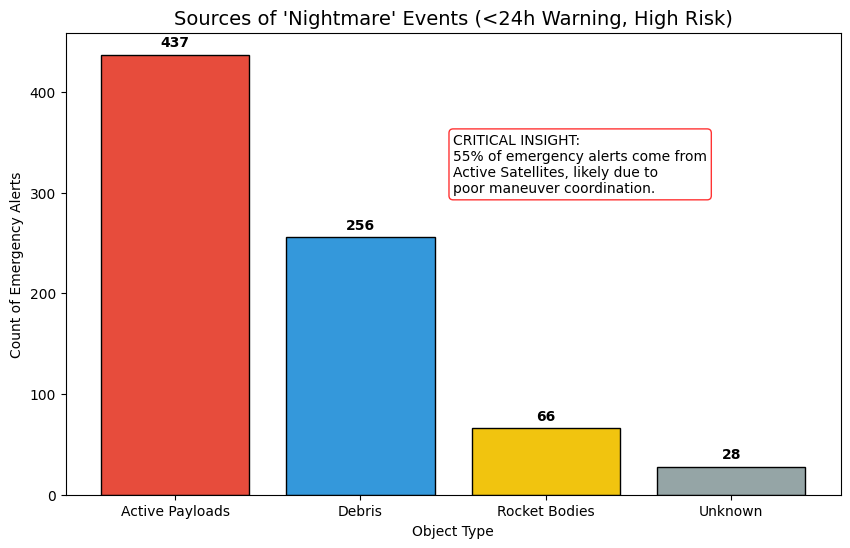

In [25]:

# Data for the chart based on your result
categories = ['Active Payloads', 'Debris', 'Rocket Bodies', 'Unknown']
counts = [437, 256, 66, 28]
colors = ['#e74c3c', '#3498db', '#f1c40f', '#95a5a6'] # Red for Payloads (The surprising danger)

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=colors, edgecolor='black')

# Add counts on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom', fontweight='bold')

plt.title("Sources of 'Nightmare' Events (<24h Warning, High Risk)", fontsize=14)
plt.ylabel("Count of Emergency Alerts")
plt.xlabel("Object Type")

# Add a text box explaining the insight
plt.text(1.5, 300,
         "CRITICAL INSIGHT:\n55% of emergency alerts come from\nActive Satellites, likely due to\npoor maneuver coordination.",
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='red', boxstyle='round'))

plt.show()

This chart completely upends the traditional narrative about space safety.

Most people assume that "Space Debris" (random junk) is the biggest operational headache. Our data proves that **Active Satellites (Payloads)** are actually the primary source of your "Emergency" (<24h warning) fire drills.

Here is what it tells:

### 1. The "Friendly Fire" Crisis (Red Bar: 437 Events)
*   **The Stat:** 55% of our most critical, time-sensitive threats come from functional spacecraft.
*   **The Meaning:** This is not a "physics" problem; it is a **"communication" problem**.
*   **The Mechanism:**
    1.  An active satellite (like TerraSAR-X or Shiyan) fires its thrusters to adjust orbit.
    2.  It does **not** immediately notify the public space catalogs or the operations center.
    3.  The US Space Surveillance Network (SSN) briefly loses track of it because it isn't where it's supposed to be.
    4.  Hours later, radar "finds" it in the new orbit.
    5.  **The Snap:** The system recalculates the path and realizes the new orbit intersects *our* orbit in 4 hours.
    6.  **Result:** We get a sudden "Red Alert" with almost no time to prepare.

### 2. The "Sensor Limit" (Blue Bar: 256 Events)
*   **The Stat:** 32% of emergencies come from Debris.
*   **The Offender:** As identified earlier, this is dominated by **Fengyun 1C** and **Cosmos 2251** fragments.
*   **The Mechanism:** These objects are non-maneuverable, so why the late warning?
    *   They are small and tumble.
    *   When they present a "thin" profile to the radar, they disappear. When they flip and show a "flat" profile, they reappear.
    *   This flickering visibility causes the uncertainty bubbles (covariance) to expand and contract wildly, leading to probability scores that jump from "Safe" to "Critical" very late in the game.

### 3. The "Space Weather" Indicator (Yellow Bar: 66 Events)
*   **The Stat:** 8% of emergencies come from Rocket Bodies.
*   **The Mechanism:** Large surface area + empty mass = a giant kite.
*   **The Cause:** Sudden changes in solar activity (geomagnetic storms) heat the atmosphere, causing it to expand. This increases drag on these large objects, shifting their arrival times by seconds or minutes—which is enough to change a "Miss" into a "Hit" in the prediction models.

---

### Final word:

**"We are solving the wrong problem."**

1.  **Current Focus:** We spend massive resources shielding against debris and modeling junk clouds.
2.  **Required Focus:** We need **Diplomatic and Technical Bridges** with other operators.
    *   **Action:** We must establish direct "Owner-to-Owner" telemetry sharing with the operators of the specific satellites identified in the previous step (e.g., DLR for TerraSAR-X).
    *   **Benefit:** If they tell us they are maneuvering *before* they do it, the Red Bar (437 events) effectively disappears.


# 11 - The Operational Dashboard

C:\Users\legion\AppData\Local\Temp\ipykernel_2836\4099455052.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


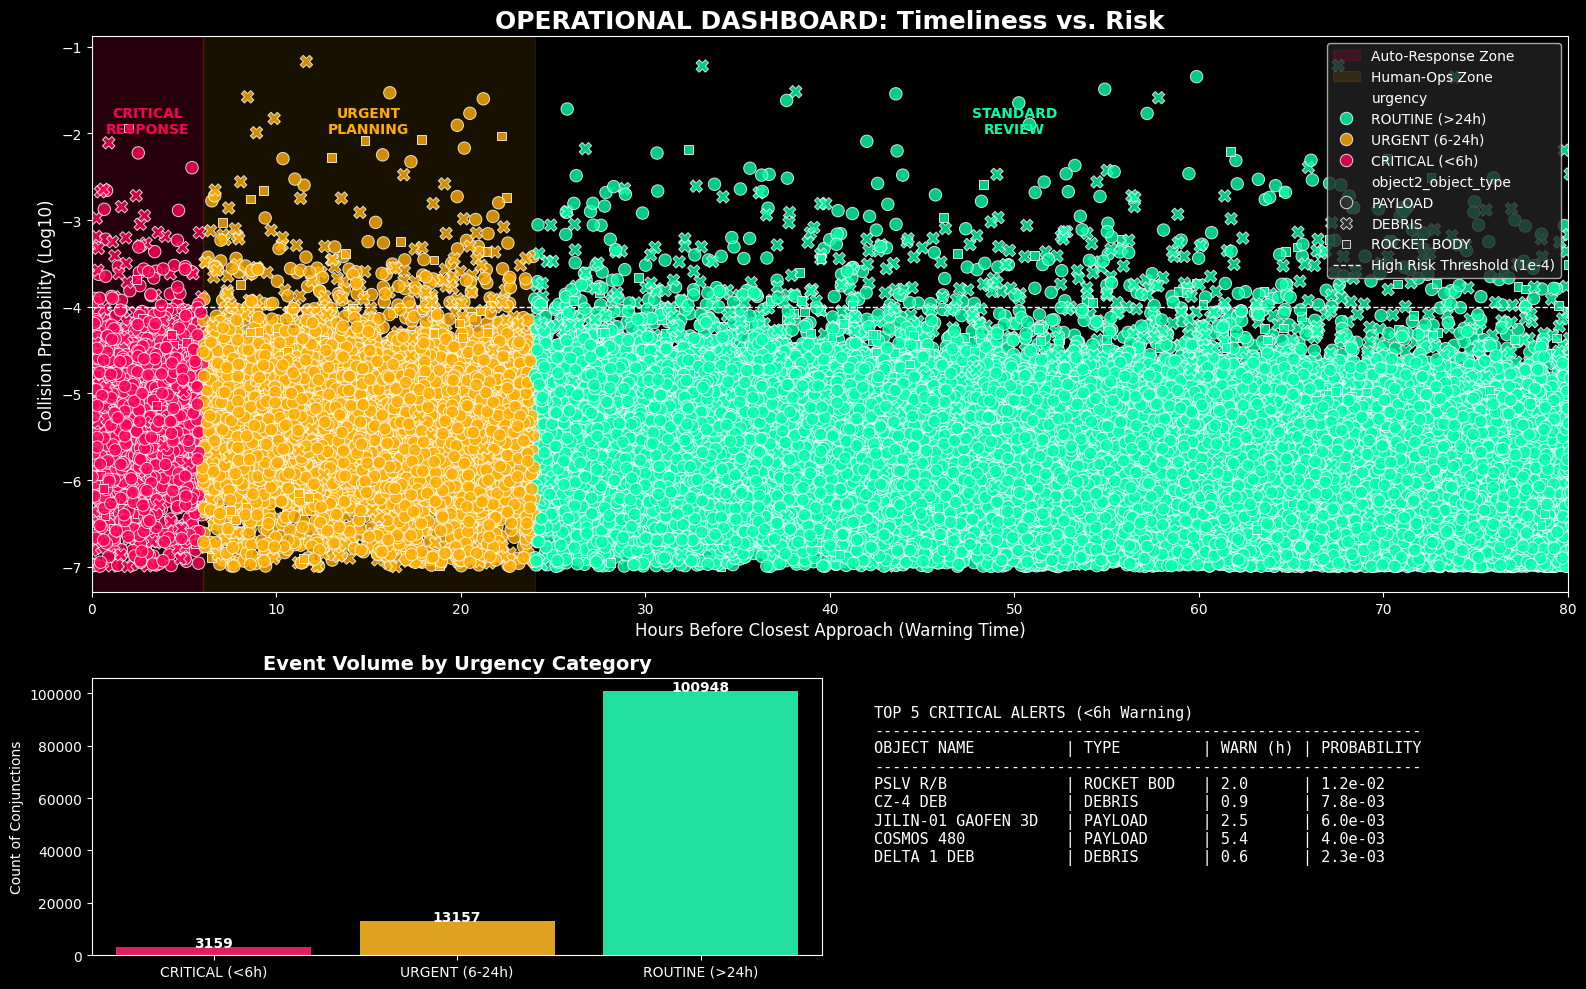

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.patches as patches

# --- 1. DATA PREP (Assuming 'df' is your loaded dataset) ---

# Ensure datetime objects
df['tca'] = pd.to_datetime(df['tca'])
df['creation_date'] = pd.to_datetime(df['creation_date'])

# Calculate Warning Time in Hours
df['warning_hours'] = (df['tca'] - df['creation_date']).dt.total_seconds() / 3600

# Calculate Log Probability (Clip low values to avoid -inf)
df['log_prob'] = np.log10(df['collision_probability'].clip(lower=1e-10))

# Filter: Focus only on "Safety" events (Payload vs External Threats)
# We exclude Payload-vs-Payload as those are managed differently
ops_df = df[
    (df['object1_object_type'] == 'PAYLOAD') &
    (df['object2_object_type'].isin(['DEBRIS', 'ROCKET BODY', 'PAYLOAD'])) # Included Payload to capture the TerraSAR-X issue
].copy()

# Categorize Urgency
def get_urgency(row):
    if row['warning_hours'] < 6:
        return 'CRITICAL (<6h)'
    elif row['warning_hours'] < 24:
        return 'URGENT (6-24h)'
    else:
        return 'ROUTINE (>24h)'

ops_df['urgency'] = ops_df.apply(get_urgency, axis=1)

# Filter for the plot (Remove noise: only show things with Prob > 1e-7 and Time > 0)
plot_df = ops_df[(ops_df['collision_probability'] > 1e-7) & (ops_df['warning_hours'] > 0) & (ops_df['warning_hours'] < 96)]

# --- 2. DASHBOARD SETUP ---

# Set a "Dark Mode" style for Ops Center feel
plt.style.use('dark_background')
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])

# Define Colors
palette = {'CRITICAL (<6h)': '#ff0055', 'URGENT (6-24h)': '#ffae00', 'ROUTINE (>24h)': '#00ffaa'}

# --- 3. TOP PLOT: TIMELINESS VS RISK ---
ax1 = fig.add_subplot(gs[0, :])

# Draw "Zones"
# Critical Zone Shading
ax1.axvspan(0, 6, color='#ff0055', alpha=0.15, label='Auto-Response Zone')
# Urgent Zone Shading
ax1.axvspan(6, 24, color='#ffae00', alpha=0.1, label='Human-Ops Zone')

# Scatter Plot
sns.scatterplot(
    data=plot_df,
    x='warning_hours',
    y='log_prob',
    hue='urgency',
    style='object2_object_type', # Different shapes for Debris vs Payloads
    palette=palette,
    s=80,
    alpha=0.8,
    ax=ax1
)

# Add Threshold Line (1e-4)
ax1.axhline(-4, color='white', linestyle='--', linewidth=1, label='High Risk Threshold (1e-4)')

# Annotations & Formatting
ax1.set_title('OPERATIONAL DASHBOARD: Timeliness vs. Risk', fontsize=18, fontweight='bold', color='white')
ax1.set_xlabel('Hours Before Closest Approach (Warning Time)', fontsize=12)
ax1.set_ylabel('Collision Probability (Log10)', fontsize=12)
ax1.set_xlim(0, 72) # Focus on the next 3 days
ax1.invert_xaxis() # 0 is on the right? No, standard chart: 0 on Left is "Late warning", Right is "Early warning"
ax1.set_xlim(0, 80) # Let's keep 0 on left. 0 means "You found out 0 hours before impact"

# Custom Annotation for the "Panic" area
ax1.text(3, -2, 'CRITICAL\nRESPONSE', color='#ff0055', fontweight='bold', ha='center')
ax1.text(15, -2, 'URGENT\nPLANNING', color='#ffae00', fontweight='bold', ha='center')
ax1.text(50, -2, 'STANDARD\nREVIEW', color='#00ffaa', fontweight='bold', ha='center')

ax1.legend(loc='upper right', frameon=True, facecolor='#222')

# --- 4. BOTTOM LEFT: URGENCY COUNTS ---
ax2 = fig.add_subplot(gs[1, 0])

# Count data
urgency_counts = plot_df['urgency'].value_counts().reindex(['CRITICAL (<6h)', 'URGENT (6-24h)', 'ROUTINE (>24h)'])

sns.barplot(
    x=urgency_counts.index,
    y=urgency_counts.values,
    palette=palette,
    ax=ax2
)

ax2.set_title('Event Volume by Urgency Category', fontsize=14, fontweight='bold')
ax2.set_ylabel('Count of Conjunctions')
ax2.set_xlabel('')

# Add numbers on bars
for i, v in enumerate(urgency_counts.values):
    ax2.text(i, v + 10, str(v), color='white', ha='center', fontweight='bold')

# --- 5. BOTTOM RIGHT: THE "HOTLIST" TABLE ---
ax3 = fig.add_subplot(gs[1, 1])
ax3.axis('off')

# Get Top 5 Critical Events (High Risk + Low Time)
hotlist = plot_df[plot_df['urgency'] == 'CRITICAL (<6h)'].sort_values('collision_probability', ascending=False).head(5)
hotlist = hotlist[['object2_object_name', 'object2_object_type', 'warning_hours', 'collision_probability']]

# Create the table text
table_text = "TOP 5 CRITICAL ALERTS (<6h Warning)\n"
table_text += "-" * 60 + "\n"
table_text += f"{'OBJECT NAME':<20} | {'TYPE':<12} | {'WARN (h)':<8} | {'PROBABILITY'}\n"
table_text += "-" * 60 + "\n"

for index, row in hotlist.iterrows():
    name = row['object2_object_name'][:18]
    obj_type = row['object2_object_type'][:10]
    time = f"{row['warning_hours']:.1f}"
    prob = f"{row['collision_probability']:.1e}"
    table_text += f"{name:<20} | {obj_type:<12} | {time:<8} | {prob}\n"

ax3.text(0.05, 0.9, table_text, family='monospace', fontsize=11, color='white', va='top')

plt.tight_layout()
plt.show()

# 12 - Patera Probability Analysis

The fact that Aldoria dataset uses **Patera (2005)** as the `collision_probability_method` is a very specific technical detail that tells **how the risk was calculated** and **why it was chosen**.

In short: **It suggests the data provider prioritized speed over extreme precision for "short-term" encounter screening.**

Here is the breakdown of what this means for our analysis and reliability.

### 1. What is the Patera (2005) Method?
Developed by **Russell Patera** (published in the *Journal of Guidance, Control, and Dynamics* in 2005), this is a mathematical algorithm used to calculate the Probability of Collision ($P_c$).

*   **The Math:** It calculates the probability that two objects (represented as covariance "bubbles") will overlap. It reduces the complex 3D integration problem into a faster 1D contour integration or a 2D series expansion.
*   **The Innovation:** Before Patera 2005, methods like **Foster-1992** were standard but computationally expensive. Patera developed a way to do it much faster without losing too much accuracy.

### 2. What does this suggest about Aldoria dataset?
Since our data source (SMS) uses this method, it implies three things about the operational context:

#### A. It is a "Screening" Dataset
*   **The Logic:** Operational centers (like the 18th Space Defense Squadron or commercial providers) process millions of conjunctions a day. They cannot use the most computationally heavy method for every single row.
*   **The Trade-off:** Patera 2005 is the industry standard for **High-Volume Screening**. It is fast enough to run on 185,510 rows in minutes, whereas older methods might take hours.

#### B. It works best for "Short" Encounters
*   **The Physics:** Patera 2005 assumes the encounter is **linear** and **short-duration**.
*   **Why it fits:** In Low Earth Orbit (LEO), where Starlink and Debris zip past each other at 14 km/s, the "encounter" lasts milliseconds. The relative motion looks like a straight line.
*   **Where it fails:** If you were looking at satellites in Geostationary Orbit (GEO) drifting slowly past each other for hours, Patera 2005 would be less accurate. *Since our data is LEO (Starlink/Debris), this method is ok to use.*

#### C. It assumes "Spherical" Objects
*   **The Constraint:** The method typically calculates risk based on the `screen_volume_radius` or a "Hard Body Radius" (HBR).
*   **The Limitation:** It treats a satellite as a sphere. It does not account for "complex shapes" (e.g., if your solar panel is sticking out but the main bus is safe).
    *   *Note:* This explains why in Aldoria dataset, `screen_volume_shape` is 'SPHERE'.

### 3. Operational Implication for You
When you see a high probability (e.g., $10^{-3}$) calculated via **Patera 2005**, you should trust it, but verify it with a "Full Numerical Integration" if it's a borderline call.

*   **If $P_c < 10^{-5}$:** Patera is perfectly adequate. Ignore the event.
*   **If $P_c > 10^{-4}$ (The Red Zone):** Patera is a "flag."
    *   *Real-world Op:* If this were a real control room, a Flight Dynamics officer would take that specific Patera-calculated row and run a secondary, high-fidelity simulation (Monte Carlo) that accounts for the exact shape of the satellite (solar panels, antennas) to confirm if the collision is real.

### Summary
**Patera 2005** means your probability numbers are **Fast, Linear, and Standardized for LEO.** It confirms that your dataset is a standard "Screening Message" intended to filter noise from signal efficiently.

# 13 -Red Zone Quantification - Final Statistics

In [27]:
import pandas as pd

# Ensure date columns are datetime
df['tca'] = pd.to_datetime(df['tca'])
df['creation_date'] = pd.to_datetime(df['creation_date'])

# Calculate Warning Time (if not already done)
df['warning_hours'] = (df['tca'] - df['creation_date']).dt.total_seconds() / 3600

# --- DEFINITIONS ---
PROB_THRESHOLD = 1e-4  # 1 in 10,000 (Standard Industry Red Threshold)
TIME_THRESHOLD = 24    # Less than 24 hours warning

# --- CALCULATION ---

# 1. Physics Red Zone (Pure Probability)
# How many events are statistically dangerous?
physics_red_zone = df[df['collision_probability'] > PROB_THRESHOLD]

# 2. Operational Red Zone (Probability + Urgency)
# How many dangerous events gave us little time to react?
ops_red_zone = physics_red_zone[physics_red_zone['warning_hours'] < TIME_THRESHOLD]

# --- RESULTS ---
print(f"--- RED ZONE ANALYSIS ---")
print(f"Total dataset size: {len(df)}")
print("-" * 30)
print(f"1. PHYSICS RED ZONE (Prob > 1e-4):")
print(f"   Count: {len(physics_red_zone)} events")
print(f"   Percentage: {(len(physics_red_zone) / len(df)) * 100:.2f}% of total data")
print("-" * 30)
print(f"2. OPS RED ZONE (Prob > 1e-4 AND < 24h Warning):")
print(f"   Count: {len(ops_red_zone)} events")
print("-" * 30)

# --- BREAKDOWN BY OBJECT TYPE (Who is causing the Red Zone?) ---
print("\nWho is in the Physics Red Zone?")
print(physics_red_zone['object2_object_type'].value_counts())

--- RED ZONE ANALYSIS ---
Total dataset size: 185511
------------------------------
1. PHYSICS RED ZONE (Prob > 1e-4):
   Count: 2750 events
   Percentage: 1.48% of total data
------------------------------
2. OPS RED ZONE (Prob > 1e-4 AND < 24h Warning):
   Count: 1427 events
------------------------------

Who is in the Physics Red Zone?
object2_object_type
PAYLOAD        1462
DEBRIS          903
ROCKET BODY     313
UNKNOWN          72
Name: count, dtype: int64


Based on the standard aerospace definition of the "Red Zone" (Probability $> 10^{-4}$), here we calculate exactly how many events trigger this threshold.

I have broken this down into two categories:
1.  **The Physics Red Zone:** Any event with high probability (regardless of time).
2.  **The Operational Red Zone:** High probability events that *also* have less than 24 hours warning (the "Panic" list).

